# Backtesting API

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import json

from pathlib import Path
import re
from datetime import datetime, timedelta
# --- Настройка путей и sys.path ---
# Добавляем корневую директорию проекта в sys.path для импорта кастомных модулей
PROJECT_ROOT = Path().cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))
from src.config import config
from src.logger import logger
from src.database import clickhouse_engine, postgres_engine, ipdr_engine   
import pandas as pd, pyarrow
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from pathlib import Path
import re
from datetime import datetime, timedelta
# --- Настройка путей и sys.path ---
# Добавляем корневую директорию проекта в sys.path для импорта кастомных модулей
PROJECT_ROOT = Path().cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))
from src.config import config
from src.logger import logger
from src.database import clickhouse_engine

Configuration loaded successfully.


2025-11-12 15:11:10,758 | my_logger - INFO - ✅ PostgreSQL engine создан | /data/aturov/scoring/src/database.py:21
2025-11-12 15:11:10,800 | my_logger - INFO - ✅ ClickHouse engine создан | /data/aturov/scoring/src/database.py:36
2025-11-12 15:11:10,802 | my_logger - INFO - ✅ IPDR ClickHouse engine создан | /data/aturov/scoring/src/database.py:46


In [2]:
config.features.SPLINT_DATE

'2024-12-01'

In [3]:
# Выгрузим номера теллефонов кредитчиков и даты получения кредитов
def make_query(engine):
    """
    Функция для выполнения SQL-запроса к базе данных и получения данных в виде DataFrame.
    Параметры:
    - engine: SQLAlchemy engine для подключения к базе данных.
    Возвращает:
    - DataFrame с результатами запроса.
    """
    query = f"""
            SELECT 
                ce.id_request,
                ce.phone_eldik, 
                ce.inn_eldik, 
                ce.id_credit, 
                ce.date_open, 
                toUInt64(ce.subscription_id) AS subscription_id,
                ce.match_phone, 
                ce.match_inn, 
                IFNULL(ce.overdue_max, 0) AS overdue_max,
                IFNULL(ce.total_overdue, 0) AS total_overdue,
                ce.status
            FROM data_science.credits_subs_eldik_clean AS ce       
    """    
    data = pd.read_sql(query, engine)
    return data
df_credits = make_query(clickhouse_engine)
# Создаем таргет: плохой клиент = 1, хороший = 0
df_credits['target'] = ((df_credits['overdue_max'] >= config.features.OVERDUE_DAYS_MAX) | 
                        (df_credits['total_overdue'] >= config.features.TOTAL_OVERDUE)| 
                        (df_credits['status'].isin(['Отказано']))).astype(int)
df_credits.shape

(20886, 12)

In [4]:
data_response = df_credits[pd.to_datetime(df_credits['date_open']) >= pd.to_datetime(config.features.SPLINT_DATE)][['phone_eldik', 'date_open', 'target']]
data_response.shape

(8007, 3)

In [5]:
import requests
from dotenv import load_dotenv

load_dotenv()
BASE_URL = os.getenv("BASE_URL", "http://10.16.230.222:7022").rstrip("/")
TIMEOUT = float(os.getenv("API_TEST_TIMEOUT", 5.0))

def _call_predict_get(payload: dict = {"phone": "996774049151", "settlement_date": "2025-11-01"}):
    """Отправка GET /predict с query params"""
    url = f"{BASE_URL}/predict"
    return requests.get(url, params=payload, timeout=TIMEOUT)



In [6]:
payload = {"phone": "996774049151", "settlement_date": "2025-11-01"}
response = _call_predict_get(payload)
response.json()

{'phone': 996774049151,
 'settlement_date': '2025-11-01',
 'probability': 0.4995518,
 'status': 'found',
 'request_id': 'e4ce3a4c-c486-4f07-b9c1-f9434d11b7de'}

In [7]:
import time


In [8]:
df_predictions = data_response[['phone_eldik', 'date_open', 'target']].copy()
for index, row in data_response.iterrows():
    # гарантируем строковый телефон и строковую дату в формате YYYY-MM-DD
    phone = pd.to_numeric(row['phone_eldik'])
    settlement_date = pd.to_datetime(row['date_open']).date()
    payload = {"phone": phone, "settlement_date": settlement_date}
    response = _call_predict_get(payload)
    result = response.json()
    # API возвращает probability — используем его, fallback на ключ 'prediction'
    predicted_value = result.get('probability')
    # пишем предсказание в df (оставляем NaN если нет)
    df_predictions.at[index, 'predicted'] = predicted_value

    logger.info(f"Phone: {phone}, Date Open: {settlement_date}, Actual Target: {row.get('target')}, Predicted: {predicted_value}")

    # небольшая пауза, чтобы не нагрузить API (при большом бэктесте увеличить)
    time.sleep(0.02)
df_predictions.to_csv(f"{config.environment.data_raw_path}/df_predictions_back_test_api.csv", index=False)
df_predictions.shape

2025-11-12 15:11:11,771 | my_logger - INFO - Phone: 996220256887, Date Open: 2024-12-02, Actual Target: 0, Predicted: None | /tmp/ipykernel_749227/2660813047.py:14
2025-11-12 15:11:11,890 | my_logger - INFO - Phone: 996777020682, Date Open: 2024-12-02, Actual Target: 0, Predicted: None | /tmp/ipykernel_749227/2660813047.py:14
2025-11-12 15:11:11,999 | my_logger - INFO - Phone: 996220256887, Date Open: 2024-12-02, Actual Target: 0, Predicted: None | /tmp/ipykernel_749227/2660813047.py:14
2025-11-12 15:11:12,114 | my_logger - INFO - Phone: 996778541468, Date Open: 2024-12-02, Actual Target: 0, Predicted: None | /tmp/ipykernel_749227/2660813047.py:14
2025-11-12 15:11:12,213 | my_logger - INFO - Phone: 996772004081, Date Open: 2024-12-02, Actual Target: 0, Predicted: None | /tmp/ipykernel_749227/2660813047.py:14
2025-11-12 15:11:12,316 | my_logger - INFO - Phone: 996770359804, Date Open: 2024-12-04, Actual Target: 0, Predicted: None | /tmp/ipykernel_749227/2660813047.py:14
2025-11-12 15:11

(8007, 4)

In [11]:
df_predictions = pd.read_csv(f"{config.environment.data_raw_path}/df_predictions_back_test_api.csv")

data_response = df_predictions.copy()
data_response.shape

(8007, 4)

In [12]:
data_response

,phone_eldik,date_open,target,predicted
0,996220256887,2024-12-02,0,NaN
1,996777020682,2024-12-02,0,NaN
2,996220256887,2024-12-02,0,NaN
3,996778541468,2024-12-02,0,NaN
4,996772004081,2024-12-02,0,NaN
...,...,...,...,...
8002,996770014435,2025-09-16,1,0.289123
8003,996775199807,2025-09-19,1,0.398134
8004,996770226223,2025-10-02,1,0.170989
8005,996220233865,2025-10-03,1,0.454971


In [17]:
data_response = data_response[~data_response['predicted'].isna()]
data_response = data_response[data_response['date_open'] < '2025-04-01']
data_response.shape

(973, 4)

In [18]:
df = data_response.copy()

# очистка
df = df.dropna(subset=['predicted', 'target']).copy()
df['target'] = df['target'].astype(int)
df['predicted'] = df['predicted'].astype(float)

# приводим дату и формируем месяц в формате YYYY-MM
df['date_open'] = pd.to_datetime(df['date_open'])
df['month'] = df['date_open'].dt.to_period('M').astype(str)

,month,n,positives,negatives,auc
0,2024-12,244,7,237,0.728752
1,2025-01,213,11,202,0.624212
2,2025-02,277,5,272,0.724265
3,2025-03,239,201,38,0.699791


Overall AUC-ROC: 0.776965 | n=973, positives=224, negatives=749


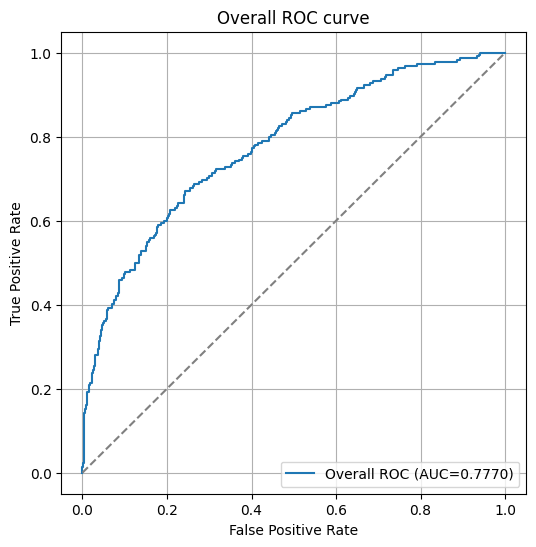

In [19]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

df = df.dropna(subset=['predicted', 'target']).copy()
df['target'] = df['target'].astype(int)
df['predicted'] = df['predicted'].astype(float)
df['date_open'] = pd.to_datetime(df['date_open'])
df['month'] = df['date_open'].dt.to_period('M').astype(str)

# собираем метрики по месяцам
rows = []
for month, g in df.groupby('month'):
    y_true = g['target'].values
    y_score = g['predicted'].values
    n = len(y_true)
    pos = int(y_true.sum())
    neg = n - pos
    if n == 0 or len(np.unique(y_true)) < 2:
        auc_val = np.nan
    else:
        try:
            auc_val = float(roc_auc_score(y_true, y_score))
        except Exception:
            auc_val = np.nan
    rows.append({"month": month, "n": n, "positives": pos, "negatives": neg, "auc": auc_val})

monthly_metrics = pd.DataFrame(rows).sort_values('month').reset_index(drop=True)
display(monthly_metrics)

# общий AUC и ROC (если есть оба класса)
if len(np.unique(df['target'])) >= 2:
    overall_auc = roc_auc_score(df['target'], df['predicted'])
    fpr, tpr, _ = roc_curve(df['target'], df['predicted'])
    print(f"Overall AUC-ROC: {overall_auc:.6f} | n={len(df)}, positives={int(df['target'].sum())}, negatives={len(df)-int(df['target'].sum())}")
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f"Overall ROC (AUC={overall_auc:.4f})")
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Overall ROC curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
else:
    print("Недостаточно классов в выборке для расчёта общего AUC (требуются both 0 и 1).")


In [20]:
# печать таблицы
print("AUC-ROC по месяцам:")
display(monthly_metrics)


AUC-ROC по месяцам:


,month,n,positives,negatives,auc
0,2024-12,244,7,237,0.728752
1,2025-01,213,11,202,0.624212
2,2025-02,277,5,272,0.724265
3,2025-03,239,201,38,0.699791


In [21]:
# посчитать pooled (общий), macro и weighted AUC
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

df = data_response.dropna(subset=['predicted','target']).copy()
df['target'] = df['target'].astype(int)
df['predicted'] = df['predicted'].astype(float)
df['date_open'] = pd.to_datetime(df['date_open'])
df['month'] = df['date_open'].dt.to_period('M').astype(str)

# pooled (micro) — то же, что вы уже печатаете как Overall AUC-ROC
pooled_auc = np.nan
if len(np.unique(df['target'])) >= 2:
    pooled_auc = roc_auc_score(df['target'], df['predicted'])
print(f"Pooled (overall) AUC = {pooled_auc:.6f}")

# monthly AUCs (как таблица)
rows = []
for month, g in df.groupby('month'):
    y_true = g['target'].values
    y_score = g['predicted'].values
    if len(np.unique(y_true)) < 2:
        auc_val = np.nan
    else:
        auc_val = float(roc_auc_score(y_true, y_score))
    rows.append({'month': month, 'n': len(g), 'positives': int(y_true.sum()), 'negatives': len(g)-int(y_true.sum()), 'auc': auc_val})
monthly = pd.DataFrame(rows).sort_values('month').reset_index(drop=True)
display(monthly)

# macro (среднее по месяцам, исключая NaN) и weighted (взвешенное по n)
macro_auc = monthly['auc'].dropna().mean()
weighted_auc = (monthly.dropna(subset=['auc']).apply(lambda r: r['auc'] * r['n'], axis=1).sum() /
                monthly.dropna(subset=['auc'])['n'].sum())
print(f"Macro AUC (mean of months) = {macro_auc:.6f}")
print(f"Weighted AUC (by month n) = {weighted_auc:.6f}")

# пояснение: pooled_auc обычно = weighted по-настоящему, но weighted по-месяцам != pooled,
# если вы усредняете/фильтруете месяцы или теряете строки с NaN.

Pooled (overall) AUC = 0.776965


,month,n,positives,negatives,auc
0,2024-12,244,7,237,0.728752
1,2025-01,213,11,202,0.624212
2,2025-02,277,5,272,0.724265
3,2025-03,239,201,38,0.699791


Macro AUC (mean of months) = 0.694255
Weighted AUC (by month n) = 0.697476
